# Autoencoder for lensed supernova detection

The objective is to build a model able to detect lensed supernova among normal supernova. For this I train a autoencoder.  

The dataset I am using comes from the notebook Hsiao_dataframe_example.ipynb. It contains data about supernova such as fluxes, time samples and the parameters on which they depend. In fact, the data are splited into two dataframes: in one hand, all the parameters needed to generate the data, and in on the other hand, the generated data (total flux + noise and time samples for each band (g, r, i).  

Some features in these datasets are not numerical such as the ID, the time delays and the magnifications (for practical reasons).  

In the following, data corresponding to (# image = 1) = normal supernova and (# image ≠ 1) = lensed supernova.

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import time
from scipy import interpolate

from sklearn.utils import shuffle
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn

import sys
print(sys.version)
print(torch.version)
print('cuda:',torch.version.cuda)

# Choose cpu/gpu
use_gpu=0
if (use_gpu):
    print('\nEnable gpu')
    dtype = torch.cuda.FloatTensor
    device = torch.device("cuda") # Uncomment this to run on GPU
    
else:
    print('\nRun on cpu')
    dtype = torch.FloatTensor
    device = torch.device("cpu")

3.9.7 (default, Sep 16 2021, 08:50:36) 
[Clang 10.0.0 ]
<module 'torch.version' from '/Users/lea/opt/anaconda3/lib/python3.9/site-packages/torch/version.py'>
cuda: None

Run on cpu


## Loading data

In [2]:
# Load data
df1 = pd.read_csv("truth.csv")
df2 = pd.read_csv("data.csv")

df2.rename(columns={'time sample band g': 'time_g', 'time sample band r': 'time_r',
                    'time sample band i': 'time_i','total flux + noise band g': 'tfnbg',
                    'total flux + noise band r': 'tfnbr', 'total flux + noise band i': 'tfnbi',}, inplace=True)

In [3]:
# Replacing nan values

def interpolation(dataframe):
    
    dataframe.reset_index(drop = True, inplace = True)
    col = dataframe.columns
    
    
    for i in range(1, len(col)):
        
        # list of nan values for each column
        nan_index = [j for j in range(len(dataframe)) if pd.isnull(dataframe.iloc[j, i])]

        if i%2!=0 and len(nan_index)!=0:       # to only have time columns
            
            # mean time range between to adjacent values
            interval = [np.mean(np.diff(dataframe.iloc[:nan_index[0],i])) for j in range(1) if (not nan_index)==False]

            for k in nan_index:
                
                # the nan value takes the previous value + interval value
                dataframe.loc[k, col[i]] = np.round(dataframe.loc[k-1, col[i]] + interval[0], 2)
        
        
        elif i%2==0 and len(nan_index)!=0:
            
            # nan values will be calculated thanks to an interpolation: 
            # the column of the fluxes will be interpolated and to fill the nan values, I will take values which
            # are nearest the corresponding time value.  
            x = dataframe[col[i-1]][:nan_index[0]]
            y = dataframe[col[i]][:nan_index[0]]
            f = interpolate.interp1d(x, y, kind='nearest', fill_value='extrapolate')
            for k in nan_index:
                dataframe.loc[k, col[i]] = f(dataframe[col[i-1]][k])        

    return dataframe

In [4]:
start = time.time()

Id = list(df1['ID'].values)
time_columns = ['time_g', 'time_r', 'time_i']
flux_columns = ('tfnbg', 'tfnbr', 'tfnbi')

new_df2 = pd.DataFrame()
for i in Id:
    print(i)
    f = df2[df2['ID'] == i]
    f = interpolation(f)
    new_df2 = pd.concat([new_df2, f])


end = time.time()
print("The time of execution of above program is :", end-start)

1-0.0962-1.4119-0.1595
1-0.0137-2.3009-0.0057
1-0.0161-1.6411-0.1583
2-0.0225-1.7856-0.1731
4-0.0624-2.3419-0.1966


/Users/lea/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


1-0.0883-1.2982-0.0363
1-0.0535-1.5897-0.1072
1-0.0093-2.0122-0.0158
1-0.0301-1.7313-0.1433
3-0.0819-1.2557-0.1669
1-0.0572-1.9363-0.0047
1-0.0563-1.1236-0.1095
3-0.0445-1.8626-0.1478
1-0.0422-2.3639-0.0572
2-0.0773-1.5312-0.0355
1-0.0327-1.6664-0.1293
1-0.026-1.7576-0.0103
4-0.0571-1.4085-0.1947
2-0.0722-1.7882-0.0157
1-0.0059-2.3355-0.0515
1-0.0156-1.3772-0.1618
1-0.0791-2.4514-0.0421
1-0.097-2.0864-0.1337
1-0.0295-2.2244-0.1485
1-0.0073-2.2849-0.1709
1-0.0335-1.3577-0.0402
1-0.024-1.8743-0.0754
1-0.0604-2.2361-0.0926
2-0.0568-2.3722-0.0716
1-0.0117-1.8968-0.1539
3-0.0565-1.2789-0.1232
1-0.0831-2.4734-0.0467
1-0.0929-1.9354-0.1084
2-0.0151-1.4895-0.0494
1-0.0492-1.9735-0.1699
1-0.0209-1.8696-0.1489
1-0.0768-1.8038-0.1145
1-0.0151-2.455-0.0735
1-0.0487-2.1213-0.0739
1-0.0095-1.291-0.0667
2-0.0679-1.1961-0.0168
2-0.0935-1.7273-0.1338
1-0.043-2.3205-0.1083
4-0.0913-1.2337-0.0102
1-0.0105-1.4668-0.0016
1-0.0079-2.1445-0.1526
2-0.0472-1.0117-0.0447
1-0.0856-2.3205-0.1971
4-0.0517-2.2041-0

2-0.0338-1.4843-0.1932
1-0.0956-1.2028-0.1434
1-0.0032-1.5161-0.1465
3-0.067-1.2733-0.0322
1-0.0682-1.6723-0.0897
4-0.0192-2.0919-0.1979
1-0.0805-1.6893-0.0995
4-0.0383-1.0025-0.114
1-0.0245-2.0581-0.0732
4-0.0106-1.0041-0.1624
3-0.1-1.2518-0.1942
1-0.0377-1.4101-0.1394
3-0.0099-1.6712-0.1576
4-0.0098-1.6359-0.1269
1-0.0246-1.5145-0.0347
1-0.0152-1.7569-0.0476
2-0.061-1.9704-0.1622
4-0.0553-1.2036-0.0516
1-0.0586-1.4131-0.071
1-0.0905-2.3313-0.0626
1-0.0513-1.8101-0.1
1-0.0483-1.4183-0.1928
2-0.096-1.1099-0.0289
1-0.0118-2.4405-0.0044
1-0.0351-1.6769-0.1027
3-0.0956-1.3832-0.0504
4-0.0433-1.9461-0.1484
1-0.0595-1.6307-0.0337
1-0.0096-1.1656-0.114
4-0.0742-1.8595-0.0572
2-0.0025-1.5109-0.0347
4-0.0683-1.089-0.1755
2-0.0474-1.723-0.068
1-0.0784-1.0725-0.1381
1-0.0346-2.0163-0.1622
1-0.0561-1.3495-0.1699
4-0.0106-1.9971-0.0587
4-0.0326-2.0543-0.1237
4-0.0771-2.0004-0.044
1-0.0744-2.0403-0.0631
1-0.0861-1.0784-0.1117
1-0.0846-2.3273-0.1618
4-0.0106-2.0531-0.1538
1-0.0311-1.9509-0.0189
1-0.

4-0.0036-2.4606-0.0879
4-0.0508-2.1539-0.1169
1-0.0433-2.1728-0.0907
2-0.0358-1.679-0.1789
1-0.0962-1.1102-0.1653
1-0.0913-1.7506-0.1021
1-0.0967-1.4485-0.0933
4-0.0485-1.7562-0.1876
3-0.0283-1.4282-0.171
1-0.0124-1.9932-0.0477
1-0.0998-1.3596-0.0385
1-0.0543-1.4294-0.0288
4-0.0238-2.0117-0.0301
4-0.0125-1.663-0.053
3-0.0085-2.2708-0.1074
3-0.0223-1.2518-0.1778
4-0.0892-1.5348-0.1838
1-0.0366-1.1822-0.1089
2-0.0582-1.4638-0.0216
4-0.0119-2.2265-0.067
1-0.0695-1.0127-0.0486
1-0.0101-2.0648-0.1478
1-0.0802-1.5357-0.0446
1-0.0945-1.5902-0.0955
2-0.0379-1.2164-0.1135
2-0.0345-1.7147-0.1641
4-0.0719-2.139-0.1634
1-0.0845-1.7955-0.0947
3-0.0811-1.5012-0.1828
1-0.0576-1.0843-0.0639
4-0.0058-2.2521-0.1276
1-0.0975-1.5211-0.016
1-0.0048-1.8794-0.0113
1-0.0663-1.0563-0.1679
1-0.0758-1.9334-0.139
1-0.0412-2.4815-0.051
2-0.0829-1.6809-0.0222
1-0.0044-2.0705-0.1901
1-0.0348-1.2443-0.061
4-0.0509-1.5128-0.0978
2-0.02-1.995-0.0286
1-0.0229-1.1277-0.1831
1-0.038-1.2482-0.0156
1-0.0436-1.964-0.1348
4-0

1-0.034-2.3043-0.1395
1-0.016-2.0295-0.151
3-0.0987-1.2226-0.0023
3-0.0765-1.972-0.0752
4-0.0344-2.1636-0.184
1-0.0593-1.6671-0.0065
1-0.0228-1.3824-0.0721
1-0.0416-2.1258-0.1366
1-0.0657-1.8718-0.1425
1-0.0394-2.3218-0.0846
1-0.0071-2.0911-0.0674
1-0.0068-1.729-0.0951
3-0.0062-2.2658-0.1171
2-0.0406-2.496-0.0187
1-0.0195-1.3708-0.1103
1-0.0106-1.1321-0.0165
1-0.0396-2.434-0.1322
1-0.0463-1.195-0.0505
1-0.0044-2.1202-0.0275
1-0.0421-2.3388-0.1176
2-0.0954-1.0103-0.0349
1-0.0559-1.1116-0.0307
2-0.0417-1.7976-0.1825
1-0.019-1.0725-0.0672
1-0.0956-2.2131-0.0117
1-0.0445-2.3877-0.0336
4-0.0534-2.2213-0.0817
1-0.0052-2.376-0.1884
2-0.0642-2.2553-0.0469
3-0.0216-1.4929-0.1501
1-0.0135-1.6505-0.1174
1-0.0482-2.2356-0.0266
1-0.0601-1.2943-0.0118
2-0.0371-2.0743-0.1841
1-0.0673-2.2294-0.0528
2-0.0899-1.4936-0.1493
1-0.047-2.2918-0.1183
1-0.0419-2.1781-0.1666
1-0.025-1.868-0.1984
1-0.0781-1.238-0.0533
4-0.098-2.2938-0.053
4-0.0438-1.656-0.1063
1-0.032-2.1699-0.1487
2-0.0458-2.0262-0.164
3-0.076-

1-0.0104-1.1401-0.1916
4-0.0828-1.1056-0.1078
3-0.0761-2.3989-0.1231
3-0.079-1.0436-0.1762
1-0.0899-2.3012-0.098
1-0.0509-1.5206-0.1221
1-0.0208-1.9518-0.0306
4-0.0609-1.8282-0.1494
1-0.0994-2.439-0.1875
1-0.0515-1.0944-0.0088
1-0.0399-2.3331-0.0051
1-0.0969-1.9173-0.1391
4-0.0002-2.4864-0.0148
1-0.064-1.4729-0.145
1-0.049-1.2466-0.0798
2-0.0173-1.7227-0.1762
1-0.0223-2.188-0.1987
1-0.0099-1.5881-0.154
4-0.0274-2.0149-0.1608
4-0.0876-1.8754-0.161
1-0.0336-1.7806-0.1169
1-0.0574-2.0892-0.0976
1-0.0506-2.3946-0.1965
1-0.0826-2.0222-0.0003
1-0.0505-2.4976-0.0472
1-0.0235-2.3133-0.197
1-0.0205-1.9958-0.123
3-0.0333-2.2892-0.0904
1-0.0906-1.9656-0.0403
1-0.0314-1.9475-0.1051
1-0.0218-1.5748-0.0221
1-0.0465-1.3125-0.1244
4-0.0597-1.0899-0.0225
1-0.0941-1.4112-0.1205
4-0.0426-1.5982-0.1392
2-0.0839-2.0846-0.0892
1-0.0746-2.4778-0.099
1-0.0823-1.6037-0.0752
1-0.0986-2.4693-0.1945
1-0.0112-2.2632-0.1498
1-0.034-1.8952-0.143
1-0.0715-1.5528-0.189
1-0.0713-2.037-0.0785
2-0.0779-2.0466-0.106
1-0.0

2-0.0161-2.4456-0.085
1-0.0871-1.1932-0.1276
2-0.0205-2.2596-0.1135
1-0.0814-2.039-0.1354
4-0.0383-1.1043-0.1854
1-0.032-1.2762-0.1824
1-0.0853-1.4603-0.0384
3-0.061-2.1065-0.1342
1-0.0046-2.4271-0.1465
3-0.0325-1.699-0.0455
1-0.0112-2.1844-0.1116
1-0.0674-1.9125-0.1985
1-0.0988-1.9499-0.1729
1-0.0482-2.3424-0.1894
1-0.095-1.7701-0.1835
1-0.0788-1.6053-0.1438
1-0.0869-1.4283-0.0629
3-0.023-2.4899-0.1423
2-0.0589-2.284-0.1145
1-0.0972-2.2695-0.1398
1-0.0537-2.1305-0.0686
1-0.0192-1.7464-0.0672
1-0.0091-1.7589-0.1575
3-0.0651-1.8958-0.0958
1-0.0818-2.162-0.1229
4-0.0107-1.8933-0.096
1-0.0819-2.3975-0.1831
1-0.0706-1.9844-0.0978
2-0.0799-2.0076-0.1042
1-0.0826-1.0578-0.1882
1-0.0301-1.0965-0.0928
1-0.0423-2.4634-0.124
3-0.0623-1.4557-0.0097
1-0.0453-1.491-0.0224
1-0.0983-1.2936-0.1397
1-0.0596-2.0998-0.1335
1-0.0789-1.6019-0.048
1-0.0835-1.9634-0.1149
4-0.008-1.3262-0.0702
3-0.0954-2.2784-0.1848
1-0.0654-1.334-0.1352
1-0.021-1.2821-0.0711
3-0.0321-1.3339-0.1812
1-0.0974-1.3448-0.1966
1-0.

4-0.0761-2.1929-0.0212
3-0.0025-2.3028-0.1971
1-0.0765-1.092-0.1767
3-0.0069-2.2416-0.1685
2-0.0475-1.5036-0.1554
1-0.0195-1.3447-0.1414
2-0.0308-1.1621-0.0241
1-0.0943-2.254-0.1248
3-0.0889-2.492-0.1575
3-0.0584-1.8223-0.0252
1-0.088-1.1105-0.1886
1-0.0392-2.1025-0.12
2-0.0269-1.1821-0.0677
3-0.0289-1.2376-0.1069
3-0.0961-1.524-0.1802
1-0.0629-1.5209-0.1405
1-0.069-1.7821-0.1848
2-0.0173-1.48-0.0299
1-0.0577-2.191-0.0548
1-0.0987-1.2424-0.1946
1-0.0149-1.9614-0.0017
1-0.0052-1.0567-0.0212
1-0.0621-1.8208-0.0928
1-0.0034-1.9545-0.1718
3-0.0446-2.0226-0.1632
1-0.0749-2.0448-0.1868
1-0.0724-1.1888-0.1002
1-0.0401-1.1595-0.167
1-0.0578-1.3681-0.0951
1-0.0794-1.6722-0.1121
1-0.0888-1.154-0.0637
4-0.0169-1.4082-0.0022
1-0.0389-2.0974-0.0972
1-0.0992-2.0086-0.0622
2-0.0961-1.4589-0.1387
3-0.0842-1.1363-0.1515
4-0.0962-1.3059-0.1887
1-0.0852-1.4552-0.077
4-0.0111-1.1274-0.1901
1-0.0414-1.9071-0.0713
1-0.0047-1.4237-0.1042
1-0.0227-2.4465-0.0684
1-0.0282-2.1687-0.0959
1-0.0652-1.4804-0.1572
1-

2-0.0815-1.8187-0.1209
3-0.0567-2.0617-0.137
3-0.0696-1.4191-0.1267
1-0.0546-1.1199-0.0248
1-0.0506-1.5697-0.1555
1-0.0078-2.252-0.063
1-0.0342-1.5672-0.0574
1-0.0967-2.0295-0.0816
1-0.0363-2.0176-0.0223
1-0.0801-1.3802-0.1649
1-0.059-1.1061-0.0086
4-0.035-1.4947-0.1113
4-0.0515-1.7544-0.0159
1-0.0099-2.2532-0.1348
1-0.0553-2.4544-0.0827
1-0.0913-1.401-0.007
3-0.0398-2.4093-0.0152
2-0.0967-2.3704-0.0931
4-0.0359-1.8756-0.0688
1-0.0911-2.1608-0.1208
1-0.0698-2.4262-0.1631
1-0.0721-1.5612-0.1877
1-0.0805-2.1649-0.1617
3-0.0182-1.1082-0.0034
1-0.0568-2.1279-0.0021
1-0.0617-2.0563-0.0165
1-0.0766-1.603-0.181
4-0.0821-1.9973-0.0532
1-0.0632-1.4867-0.1486
1-0.0031-1.7345-0.1769
1-0.0272-2.4508-0.0244
4-0.0686-2.1926-0.0635
1-0.0457-2.0083-0.1002
2-0.065-1.1611-0.1253
1-0.0896-1.5536-0.1556
4-0.0184-2.4254-0.0826
1-0.028-1.743-0.0022
4-0.0408-2.2607-0.1631
4-0.0053-2.0643-0.1207
2-0.0991-2.12-0.0118
1-0.0928-1.33-0.1344
2-0.0392-1.8758-0.0512
3-0.0137-1.4196-0.1586
2-0.0261-2.0615-0.0059
1-0.

2-0.01-2.3624-0.0088
2-0.0893-1.9411-0.016
1-0.0547-1.5469-0.1401
1-0.0815-1.5095-0.0962
4-0.0999-2.0233-0.1708
1-0.0326-2.2457-0.0444
1-0.0649-1.0464-0.0833
1-0.0904-1.538-0.1284
1-0.0071-1.6981-0.0867
1-0.0934-1.2912-0.0254
1-0.061-2.0699-0.0818
1-0.0403-1.936-0.072
4-0.0348-1.9878-0.1458
1-0.0707-1.9356-0.083
3-0.0772-1.0463-0.1358
2-0.0199-2.0658-0.0422
1-0.0542-2.1852-0.0608
2-0.0606-1.9993-0.0677
1-0.0556-2.1879-0.1946
1-0.0181-1.3957-0.0594
2-0.0189-1.7834-0.0156
1-0.007-2.2491-0.0795
1-0.0367-1.7863-0.1686
1-0.0275-2.3782-0.1105
1-0.0574-1.5922-0.1378
1-0.0142-2.2085-0.0781
2-0.0203-1.6645-0.0187
1-0.0767-2.0218-0.1705
1-0.0101-1.5986-0.0822
1-0.0225-1.3799-0.1992
1-0.0081-1.9854-0.0055
1-0.0155-2.0268-0.0366
1-0.0023-2.4599-0.0729
1-0.0799-1.4616-0.1081
1-0.0027-1.7138-0.0757
1-0.0134-1.5649-0.0313
3-0.0242-2.0532-0.1394
1-0.025-2.4402-0.0951
2-0.0721-1.584-0.0139
1-0.0411-1.5241-0.1508
1-0.0193-1.8139-0.1084
2-0.0692-1.5915-0.1793
4-0.0587-2.0438-0.0957
1-0.0843-1.265-0.1067


1-0.0064-1.8282-0.1662
1-0.0313-1.5213-0.181
1-0.0027-2.447-0.1675
1-0.0121-2.2472-0.0223
1-0.0109-2.4826-0.1823
1-0.0657-1.9292-0.0375
1-0.005-2.415-0.1368
4-0.0629-2.2114-0.1752
1-0.0186-2.1289-0.1182
1-0.034-2.4107-0.1937
1-0.0211-2.3428-0.1884
1-0.0077-1.2907-0.1158
1-0.0428-2.16-0.193
1-0.0103-1.5047-0.1557
4-0.0371-2.3491-0.153
1-0.022-2.2557-0.1322
1-0.0162-1.2074-0.1213
3-0.0413-2.0862-0.115
3-0.0267-2.1125-0.1488
1-0.0903-1.1852-0.0957
4-0.0286-2.4205-0.0048
3-0.0706-1.324-0.169
4-0.0248-1.8208-0.1185
2-0.0078-2.3762-0.1584
1-0.0199-1.737-0.1115
1-0.0504-1.4924-0.1931
1-0.0691-1.6606-0.1354
1-0.093-2.3513-0.0444
3-0.0683-1.6564-0.0268
1-0.0172-1.4695-0.0819
1-0.0093-2.2711-0.0081
1-0.0054-1.2944-0.0313
1-0.0345-1.4032-0.176
1-0.075-1.3905-0.1667
1-0.0146-2.0987-0.1231
1-0.0927-2.0241-0.1499
1-0.0416-2.1155-0.1297
1-0.0207-1.6384-0.1967
3-0.048-1.4143-0.119
1-0.0016-1.1585-0.1976
1-0.0995-2.4172-0.087
1-0.022-1.6555-0.0368
4-0.0668-1.6707-0.0996
1-0.0235-2.2803-0.0108
4-0.0425-

1-0.0725-2.1621-0.1262
1-0.0842-1.9939-0.1481
1-0.0661-2.447-0.0973
1-0.0454-1.046-0.023
1-0.041-1.8003-0.1516
1-0.0843-1.1856-0.0198
2-0.0679-1.9707-0.022
1-0.0313-1.1388-0.1022
4-0.0158-1.7905-0.057
4-0.0268-1.9322-0.157
4-0.0652-1.1945-0.1037
1-0.0952-1.0483-0.0366
2-0.0484-2.1007-0.1627
1-0.0227-1.1983-0.1247
1-0.0649-1.5084-0.0642
1-0.0642-1.5392-0.1012
1-0.0138-2.4484-0.0333
1-0.0133-1.2501-0.0519
2-0.0164-1.8398-0.108
1-0.0156-1.532-0.0036
1-0.0701-2.2136-0.1403
1-0.0541-1.3575-0.0252
1-0.0253-1.0387-0.1064
1-0.0655-1.0888-0.1471
1-0.0205-1.8939-0.168
1-0.038-1.1007-0.0903
2-0.0963-1.2309-0.0238
1-0.0903-1.2992-0.0445
1-0.0651-2.0493-0.1738
1-0.0782-1.3288-0.0054
3-0.0613-1.7594-0.0578
1-0.0976-1.1304-0.0889
1-0.0826-2.2722-0.0715
1-0.0055-2.0615-0.1067
1-0.0606-1.078-0.0616
1-0.0419-2.1644-0.1075
1-0.04-2.1905-0.1194
1-0.0678-1.5103-0.1328
1-0.0798-1.3602-0.0076
2-0.0843-1.3642-0.1612
1-0.078-1.8037-0.0562
4-0.0062-1.8987-0.1961
1-0.0284-2.1352-0.0755
1-0.025-1.4468-0.0684
1-0.

1-0.0672-1.4977-0.154
1-0.0433-1.8715-0.1772
3-0.0128-1.9987-0.0202
1-0.0998-1.1351-0.0048
1-0.0466-1.5042-0.0689
1-0.0683-1.4535-0.0104
2-0.0311-1.2475-0.065
4-0.0008-1.3117-0.0781
1-0.0753-2.2123-0.0551
1-0.0612-1.9103-0.1332
1-0.0448-2.32-0.1929
1-0.0471-2.2896-0.1429
1-0.0208-1.3269-0.1035
1-0.074-1.8004-0.1445
1-0.0573-1.1359-0.0609
4-0.0881-1.8005-0.0034
2-0.0893-1.4094-0.0528
1-0.0817-1.1546-0.0872
1-0.0885-2.1557-0.0691
2-0.0713-1.8775-0.1063
1-0.0486-1.176-0.1896
3-0.0749-1.3412-0.1771
1-0.0273-1.0271-0.1019
1-0.0796-2.195-0.1924
1-0.0076-2.1549-0.1238
1-0.0193-1.3258-0.1316
1-0.0231-1.506-0.0853
3-0.0356-1.7168-0.192
1-0.0848-1.1617-0.0131
1-0.0661-1.8989-0.0594
1-0.023-1.4832-0.1339
3-0.0581-2.0985-0.0195
1-0.0958-1.9028-0.0191
1-0.08-2.0535-0.1637
1-0.0345-2.3431-0.1681
2-0.0795-2.0777-0.0257
1-0.0961-2.1997-0.0021
1-0.0601-1.0298-0.0272
1-0.0394-2.1231-0.1275
4-0.0547-1.0152-0.0897
1-0.0682-1.9599-0.1371
1-0.0312-2.1301-0.0642
1-0.0439-1.2967-0.0749
1-0.0679-1.7991-0.0342


3-0.0266-2.1334-0.008
4-0.0538-2.3069-0.0821
1-0.0728-1.1315-0.068
1-0.019-1.5253-0.0967
1-0.0626-1.8998-0.1851
2-0.0795-2.047-0.1964
1-0.0308-2.242-0.1452
1-0.0481-2.382-0.075
1-0.0332-1.0213-0.115
1-0.0657-1.9287-0.1799
2-0.0044-1.5647-0.0897
1-0.0509-2.4508-0.0056
1-0.0483-2.2224-0.1232
2-0.0551-2.1011-0.016
2-0.0045-1.5005-0.0102
1-0.0156-1.7011-0.1104
3-0.0303-1.4543-0.0924
1-0.0902-1.9993-0.0171
2-0.0374-2.4315-0.1409
1-0.0485-2.284-0.048
1-0.0484-2.3132-0.0516
3-0.0558-2.2738-0.1859
1-0.0027-1.7661-0.0579
1-0.0521-2.328-0.0213
3-0.0219-1.1784-0.0656
1-0.0543-1.1759-0.1387
1-0.0495-1.6291-0.0964
3-0.0139-1.4245-0.0388
1-0.0688-1.5931-0.1333
1-0.0645-1.4753-0.1754
1-0.0465-1.755-0.0955
1-0.0261-1.4056-0.0565
1-0.067-1.1715-0.1589
1-0.0899-1.827-0.1308
3-0.0965-2.178-0.1413
1-0.0789-1.6062-0.0363
1-0.0617-2.2901-0.144
4-0.039-1.4472-0.0497
1-0.0842-1.7315-0.1744
1-0.0925-1.1234-0.1849
3-0.0153-1.1159-0.1041
1-0.0313-2.3257-0.1336
4-0.0792-2.275-0.1904
1-0.0149-1.0787-0.1232
3-0.037

4-0.0405-2.0289-0.1207
1-0.0295-2.4073-0.1338
1-0.0114-1.4085-0.0714
1-0.0895-1.3364-0.0444
1-0.0201-2.1983-0.115
1-0.0864-2.3093-0.1083
2-0.0446-1.7929-0.1632
1-0.0219-1.693-0.1289
1-0.0324-1.229-0.1324
1-0.0369-1.799-0.0204
1-0.0716-1.0003-0.1791
1-0.0932-1.4446-0.1619
1-0.0881-1.1478-0.1017
1-0.0038-2.3193-0.1849
1-0.0499-1.4803-0.1879
1-0.071-2.0993-0.164
1-0.0988-1.0557-0.0158
4-0.0506-2.4867-0.0598
1-0.0749-1.0235-0.153
1-0.0379-1.0151-0.1627
1-0.0577-2.126-0.1286
1-0.0701-1.7783-0.0774
1-0.0156-1.3074-0.1877
1-0.075-1.4466-0.0005
4-0.032-2.0366-0.1854
1-0.0299-2.357-0.0971
1-0.022-2.0961-0.1025
1-0.0747-1.2402-0.1694
2-0.082-1.5095-0.1709
1-0.0161-2.3776-0.1985
1-0.0523-1.061-0.086
1-0.0946-1.0473-0.0057
3-0.0781-2.2367-0.0023
1-0.0697-2.0914-0.0638
1-0.064-1.0225-0.1414
1-0.0159-2.3987-0.0151
1-0.0553-1.8349-0.078
1-0.0912-1.6916-0.1638
1-0.0322-2.4814-0.169
3-0.0852-1.9961-0.0004
1-0.0068-2.012-0.1862
1-0.0129-1.7508-0.1379
1-0.0639-1.4468-0.1758
1-0.0852-1.8193-0.1808
1-0.080

In [10]:
new_df2

,ID,time_g,tfnbg,time_r,tfnbr,time_i,tfnbi
0,1-0.0962-1.4119-0.1595,54965.8,2286.870275,54966.80,4789.018055,54968.20,60975.710939
1,1-0.0962-1.4119-0.1595,54968.6,8904.996271,54969.60,27607.343911,54973.40,21530.000879
2,1-0.0962-1.4119-0.1595,54971.4,12121.092679,54970.40,-23172.152124,54976.60,38634.842975
3,1-0.0962-1.4119-0.1595,54973.2,-47140.248713,54973.20,504.549232,54979.80,35926.039644
4,1-0.0962-1.4119-0.1595,54974.0,45425.527944,54974.00,5442.310948,54984.00,106884.036868
...,...,...,...,...,...,...,...
86,1-0.07-1.2321-0.0816,55128.6,-10011.038340,55116.60,-1742.088873,55419.11,7554.525035
87,1-0.07-1.2321-0.0816,55129.4,-278.735937,55117.40,1804.681032,55424.34,7554.525035
88,1-0.07-1.2321-0.0816,55132.2,10784.083371,55118.20,3618.485232,55429.57,7554.525035
89,1-0.07-1.2321-0.0816,55136.0,6079.463671,55120.00,-539.731737,55434.80,7554.525035


In [15]:
# Get events for each class
#--------------------------
index_normal = '|'.join(list(df1['ID'][df1.images==1].values))
mask_normal = new_df2['ID'].str.contains(index_normal, case = False, na = False)
index_lensed = '|'.join(list(df1['ID'][df1.images!=1].values))
mask_lensed = new_df2['ID'].str.contains(index_lensed, case = False, na = False)

normal = new_df2[mask_normal]  # 'Normal' supernova
lensed  = new_df2[mask_lensed]  # Lensed supernova

In [19]:
# Remove target (not needed)
drop=['ID']
lensed  = lensed.drop(columns=drop)
normal = normal.drop(columns=drop)

## Split data

In [28]:
import sklearn.model_selection
from sklearn.model_selection import train_test_split
# Split normal in two parts (train and test)

x_train_normal, x_test_normal = train_test_split(normal.values, test_size=0.5, random_state=13) 

# test lensed
x_test_lensed = lensed.values

print('x_train=', x_train_normal.shape,  'x_test_back=', x_test_normal.shape, 'x_test_signal=', x_test_lensed.shape)

x_train= (150878, 6) x_test_back= (150878, 6) x_test_signal= (153244, 6)


## Look at data

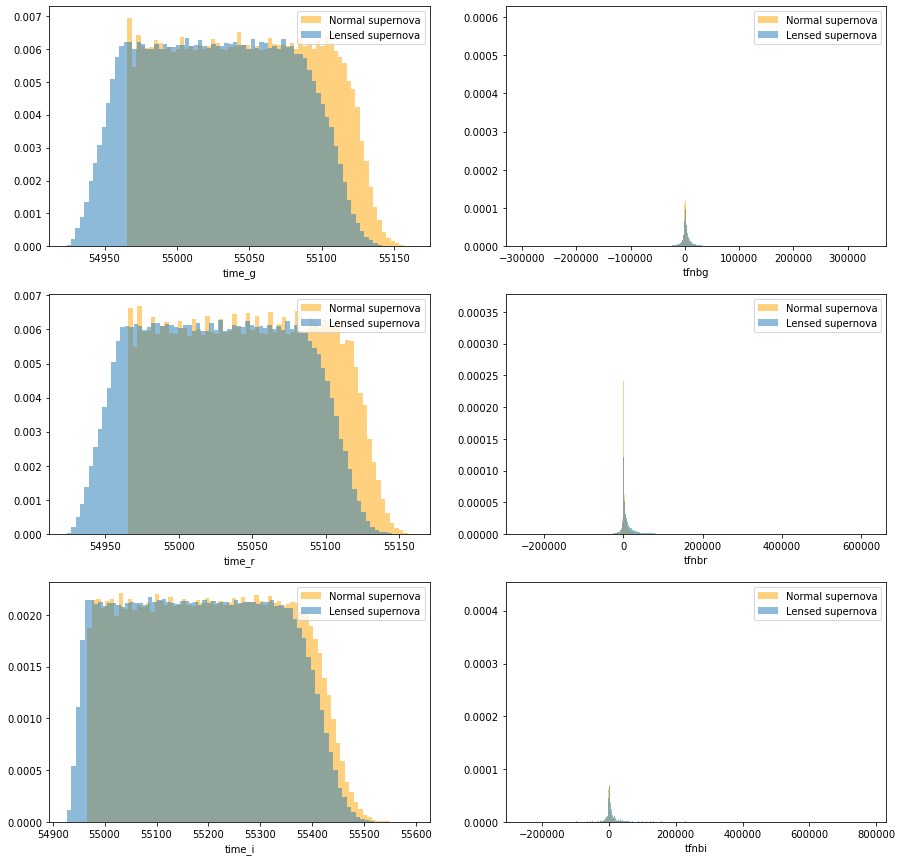

In [29]:
# plots

varname = list(lensed.columns)
plt.figure(figsize=(15, 15))
for i in range(6):
    plt.subplot(3, 2, i+1)
    n, bins, patches = plt.hist(x_test_normal[:,i], bins='auto', color = 'orange', alpha=0.5, label='Normal supernova', density=1)
    plt.hist(x_test_lensed[:,i], bins = 'auto', alpha=0.5, label='Lensed supernova', density=1)
    plt.xlabel(varname[i])
    plt.legend(loc='best')

## Rescale data

Since features have different range I apply a transformation to each feature. For this I use the MinMaxScaler that scales and translates each feature individually such that it is in the given range on the training set, e.g. between zero and one.

In [31]:
# Rescale data
#-------------
scaler = MinMaxScaler()

# fit (get min and max) and transform x_train
x_train_normal = scaler.fit_transform(x_train_normal)

# transform x_test (using scale parameters of x_train)
x_test_normal = scaler.transform(x_test_normal)
x_test_lensed = scaler.transform(x_test_lensed)

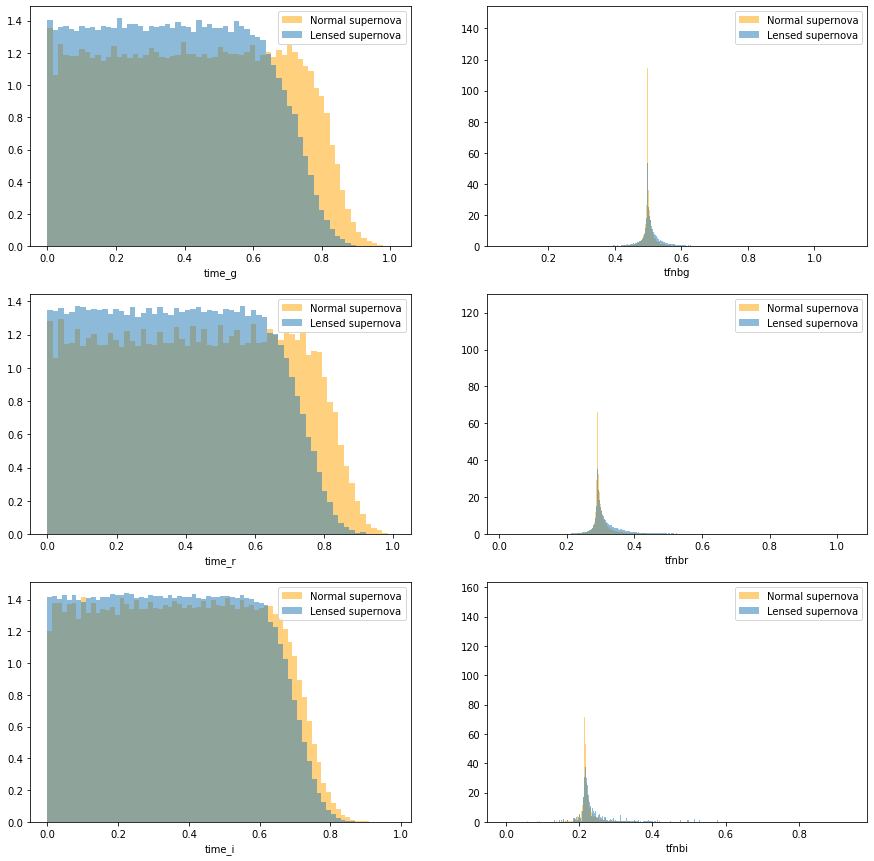

In [32]:
# Show variables after rescaling

plt.figure(figsize=(15, 15))
for i in range(6):
    plt.subplot(3, 2, i+1)
    n, bins, patches = plt.hist(x_test_normal[:,i], bins='auto', color = 'orange', alpha=0.5, label='Normal supernova', density=1)
    plt.hist(x_test_lensed[:,i], bins, alpha=0.5, label='Lensed supernova', density=1)
    plt.xlabel(varname[i])
    plt.legend(loc='best')

## Partition training data

I will train my model on 80% of the data and validate it on the 20% of the remaining training data.

In [34]:
x_train_train,x_train_valid = train_test_split(x_train_normal,test_size=0.2,random_state=13) 
print(x_train_train.shape)
print(x_train_valid.shape)

(120702, 6)
(30176, 6)


## Autoencoder model

The network has a 30-100-100-15-100-100-30 structure.

### Hyperparameters of the network

In [35]:
num_epochs = 100
batch_size = 2048
hidden_layer1 = 30
hidden_layer2 = 25
encoding_dim = 20

### AutoEncoder structure

In [36]:
input_dim = x_train_train.shape[1]

class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_layer1),
            nn.Sigmoid(),
            nn.Linear(hidden_layer1, hidden_layer2),
            nn.Sigmoid(),
            nn.Linear(hidden_layer2, encoding_dim),
            nn.Sigmoid()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, hidden_layer2),
            nn.Sigmoid(),
            nn.Linear(hidden_layer2, hidden_layer1),
            nn.Sigmoid(),
            nn.Linear(hidden_layer1,input_dim),
            #nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
# Settings
if (use_gpu):
    model = autoencoder().cuda() # enable GPU
else:
    model = autoencoder()

### Data loading utilities

In [37]:
# For training on normal samples
train_loader = torch.utils.data.DataLoader(dataset=x_train_train,
                                          batch_size=batch_size,
                                          shuffle=True)

valid_loader = torch.utils.data.DataLoader(dataset=x_train_valid,
                                          batch_size=batch_size,
                                          shuffle=True)

# For testing on lensed examples (shuffle=False)
test_fraud_loader = torch.utils.data.DataLoader(dataset=x_test_lensed,
                                          batch_size=batch_size,
                                          shuffle=False)

# For testing on unseen normal sample (shuffle=False)
test_normal_loader = torch.utils.data.DataLoader(dataset=x_test_normal,
                                          batch_size=batch_size,
                                          shuffle=False)



### Training on lensed samples

epoch [1/100], train loss:0.0336, validation loss:0.0336
epoch [50/100], train loss:0.0010, validation loss:0.0011
epoch [100/100], train loss:0.0010, validation loss:0.0009
Final train loss value: 0.0010


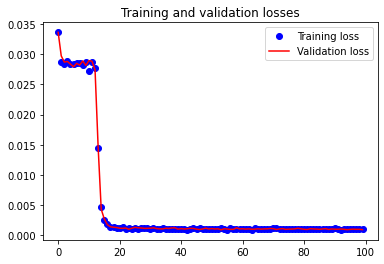

In [38]:
# Loss function
criterion = nn.MSELoss()

# Optimizer
learning_rate = 0.001  # default is 0.001

optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

# Train
train_loss = []
valid_loss = []

for epoch in range(num_epochs):
    
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for data in train_loader:
        data = data.type(dtype)
        
        output = model(data)
                
        loss = criterion(output, data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # record train loss
    train_loss.append(loss.item())

    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    for data in valid_loader:
        data = data.type(dtype)
        output = model(data)
        loss = criterion(output, data)
        
    # record validation loss
    valid_loss.append(loss.item())    
    
    if (epoch==0 or (epoch+1)%50==0):
        print('epoch [{}/{}], train loss:{:.4f}, validation loss:{:.4f}'.format(epoch + 1, num_epochs, train_loss[-1],valid_loss[-1]))
    
print('Final train loss value: %.4f' % train_loss[-1])

# Plot model performance
epochs = range(num_epochs)
plt.figure()
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, valid_loss, 'r-', label='Validation loss')
plt.title('Training and validation losses')
plt.legend()